In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from scipy.sparse import hstack
from scipy.special import logit, expit

import re
import string
import pickle

import os
import gensim
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

from sklearn.externals import joblib

/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
#pull data
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# train = pd.read_csv('/Users/randy/Documents/GitHub/Twitch_Chat_Harassment/toxic_comment_classification/jigsaw-toxic-comment-classification-challenge/cleaned_train.csv').fillna(' ')
# test = pd.read_csv('/Users/randy/Documents/GitHub/Twitch_Chat_Harassment/toxic_comment_classification/jigsaw-toxic-comment-classification-challenge/cleaned_test.csv').fillna(' ')

train = pd.read_csv('../jigsaw-toxic-comment-classification-challenge/train.csv').fillna(' ')
test = pd.read_csv('../jigsaw-toxic-comment-classification-challenge/test.csv').fillna(' ')



# Clean the Data

In [4]:
#remove non-ascii characters
def remove_non_ascii(text):
    text  = "".join([char for char in text if char in string.printable])
    text = re.sub('[0-9]+', '', text)
    return text

train['comment_text'] = train['comment_text'].apply(lambda x: remove_non_ascii(x))
test['comment_text'] = test['comment_text'].apply(lambda x: remove_non_ascii(x))

In [5]:
list_sentences_train = train['comment_text']
list_sentences_test = test['comment_text']
all_text = pd.concat([list_sentences_train, list_sentences_test])

In [6]:
#separate comments into ones where each class name = 1. It's also in another function further down.
toxic = list_sentences_train.loc[train['toxic'] == 1]
severe_toxic = list_sentences_train.loc[train['severe_toxic'] == 1]
obscene = list_sentences_train.loc[train['obscene'] == 1]
threat = list_sentences_train.loc[train['threat'] == 1]
insult = list_sentences_train.loc[train['insult'] == 1]
identity_hate = list_sentences_train.loc[train['identity_hate'] == 1]

In [10]:
#remove/change stopwords
# cl_path = '/Users/randy/Documents/GitHub/Twitch_Chat_Harassment/toxic_comment_classification/jigsaw-toxic-comment-classification-challenge/cleanwords.txt'
cl_path = './cleaning/clean_letters.txt'
clean_word_dict = {}
with open(cl_path, 'r', encoding='utf-8') as cl:
    for line in cl:
        line = line.strip('\n')
        typo, correct = line.split(',')
        clean_word_dict[typo] = correct

def clean_word(text):
    replace_numbers = re.compile(r'\d+', re.IGNORECASE)
    special_character_removal = re.compile(r'[^a-z\d ]', re.IGNORECASE)

    text = text.lower()
    text = re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", "", text)
    text = re.sub(r"(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}", "", text)

    for typo, correct in clean_word_dict.items():
        text = re.sub(typo, " " + correct + " ", text)

    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"i’m", "i am", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = replace_numbers.sub('', text)
    return text

In [11]:
train_text = []
test_text = []
toxic_text = []
severe_toxic_text = []
obscene_text = []
threat_text = []
insult_text = []
identity_hate_text = []

for text in list_sentences_train:
    train_text.append(clean_word(text))
    
for text in list_sentences_test:
    test_text.append(clean_word(text))
    
for text in toxic:
    toxic_text.append(clean_word(text))

for text in severe_toxic_text:
    severe_toxic_text.append(clean_word(text))

for text in obscene_text:
    obscene_text.append(clean_word(text))

for text in threat:
    threat_text.append(clean_word(text))

for text in insult:
    insult_text.append(clean_word(text))

for text in identity_hate:
    identity_hate_text.append(clean_word(text))

# Apply TF-IDF Vectorizer

In [12]:
#used for logit
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 1),
    stop_words='english',
    max_features=30000)
char_vectorizer.fit(all_text)

train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

In [13]:
#used for EFC
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 1),
    stop_words='english',
    max_features=30000)
word_vectorizer.fit(all_text)

train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

# Apply CountVectorizers

In [11]:
def create_df_of_toxic_category(category_string):
    '''category string must match train dataframe column name exactly ''' 
    filtered_sentences = list_sentences_train.loc[train[category_string] == 1]
    category_vectorizer = CountVectorizer(
        strip_accents='unicode',
        analyzer='word',
        ngram_range=(1, 1),
        stop_words='english',
        max_features=30000)
    category_vec_fit = category_vectorizer.fit(filtered_sentences)

    category_count_features = category_vectorizer.transform(filtered_sentences)
    category_count_df = pd.DataFrame(category_vec_fit.get_feature_names())
    category_count_df['counts'] = category_count_features.toarray().sum(axis=0)
    category_count_df.rename(columns = {0: 'word'})
    return category_count_df, filtered_sentences

In [12]:
class_specific_vocab_dict = dict()
class_specific_sentences = dict()
for class_name in class_names:
    class_specific_vocab_dict[class_name] = \
        create_df_of_toxic_category(class_name)[0].sort_values('counts', ascending = False)
    class_specific_sentences[class_name] =\
            create_df_of_toxic_category(class_name)[1]

In [ ]:
# toxic_string = ''
# for line in class_specific_sentences['toxic']:
#     toxic_string+=' ' + line

# Applying Logistic Regression

In [14]:
#this is kept for heroku purposes
train_features = train_word_features
test_features = test_word_features

In [15]:
losses = []
log_predictions = {}
log_predictions = {'id': test['id']}
log_models = {}
for class_name in class_names:
    train_target = train[class_name]
    log_classifier = LogisticRegression(solver='sag')
    log_classifier.fit(train_features, train_target)
    
    print('Accuracy of logistic regression classifier on {} set: {:.5f}'.format(class_name,log_classifier.score(train_features, train_target)))
    
    cv_loss = np.mean(cross_val_score(log_classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    losses.append(cv_loss)
    print('CV score for class {} is {}'.format(class_name, cv_loss))
    
    log_models[class_name] = log_classifier
    log_predictions[class_name] = log_classifier.predict_proba(test_features)[:, 1]


Accuracy of logistic regression classifier on toxic set: 0.96206
CV score for class toxic is 0.9701985984894529
Accuracy of logistic regression classifier on severe_toxic set: 0.99103
CV score for class severe_toxic is 0.985838146677951
Accuracy of logistic regression classifier on obscene set: 0.98003
CV score for class obscene is 0.9858707632343626
Accuracy of logistic regression classifier on threat set: 0.99729
CV score for class threat is 0.9823501814748835
Accuracy of logistic regression classifier on insult set: 0.97317
CV score for class insult is 0.9768842437544524
Accuracy of logistic regression classifier on identity_hate set: 0.99241
CV score for class identity_hate is 0.9750107955106208


In [ ]:
# #pickle the models
# # Save Model as a pickle Using joblib

  
# # Save the model as a pickle in a file 
# joblib.dump(log_models, 'Logistic_Regression_models.p')
# pickle.dump(train_char_features, open("train_char_features_vectorizer.p", "wb"))
# pickle.dump(test_char_features, open("test_char_features_vectorizer.p", "wb"))
# pickle.dump(word_vectorizer.fit(all_text), open("log_word_vectorizer.p", "wb"))

  
# # Load the model from the file 
# # pickled_models = joblib.load('models.p')

# ROC Curve

## Train-Test-Split

In [16]:
#train test split
X_train_toxic, X_test_toxic, y_train_toxic, y_test_toxic = train_test_split(\
    train_features,train['toxic'], test_size=0.2, random_state=42)

X_train_severe_toxic, X_test_severe_toxic, y_train_severe_toxic, y_test_severe_toxic = train_test_split(\
    train_features,train['severe_toxic'], test_size=0.2, random_state=42)

X_train_obscene, X_test_obscene, y_train_obscene, y_test_obscene = train_test_split(\
    train_features,train['obscene'], test_size=0.2, random_state=42)

X_train_threat, X_test_threat, y_train_threat, y_test_threat = train_test_split(\
    train_features,train['threat'], test_size=0.2, random_state=42)

X_train_insult, X_test_insult, y_train_insult, y_test_insult = train_test_split(\
    train_features,train['insult'], test_size=0.2, random_state=42)

X_train_identity_hate, X_test_identity_hate, y_train_identity_hate, y_test_identity_hate = train_test_split(\
    train_features,train['identity_hate'], test_size=0.2, random_state=42)

## Use GridSearch with Logit

In [17]:
#fit to model (logit)
penalty = ['l2']
C = np.logspace(0, 4, 10)
param_grid = dict(C=C, penalty=penalty)

logit_models = {}
# for class_name in class_names:

#toxic
logistic_toxic = linear_model.LogisticRegression(solver='lbfgs')
logistic_grid_toxic = GridSearchCV(logistic_toxic, param_grid, cv=5, scoring='roc_auc', verbose=30, n_jobs=-1)
logistic_grid_toxic.fit(X_train_toxic, y_train_toxic)

#severe_toxic
logistic_severe_toxic = linear_model.LogisticRegression(solver='lbfgs')
logistic_grid_severe_toxic = GridSearchCV(logistic_severe_toxic, param_grid, cv=5, scoring='roc_auc', verbose=30, n_jobs=-1)
logistic_grid_severe_toxic.fit(X_train_severe_toxic, y_train_severe_toxic)

#obscene
logistic_obscene = linear_model.LogisticRegression(solver='lbfgs')
logistic_grid_obscene = GridSearchCV(logistic_obscene, param_grid, cv=5, scoring='roc_auc', verbose=30, n_jobs=-1)
logistic_grid_obscene.fit(X_train_obscene, y_train_obscene)

#threat
logistic_threat = linear_model.LogisticRegression(solver='lbfgs')
logistic_grid_threat = GridSearchCV(logistic_threat, param_grid, cv=5, scoring='roc_auc', verbose=30, n_jobs=-1)
logistic_grid_threat.fit(X_train_threat, y_train_threat)

#insult
logistic_insult = linear_model.LogisticRegression(solver='lbfgs')
logistic_grid_insult = GridSearchCV(logistic_insult, param_grid, cv=5, scoring='roc_auc', verbose=30, n_jobs=-1)
logistic_grid_insult.fit(X_train_insult, y_train_insult)

#identity_hate
logistic_identity_hate = linear_model.LogisticRegression(solver='lbfgs')
logistic_grid_identity_hate = GridSearchCV(logistic_identity_hate, param_grid, cv=5, scoring='roc_auc', verbose=30, n_jobs=-1)
logistic_grid_identity_hate.fit(X_train_identity_hate, y_train_identity_hate)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.2s
[Paralle

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'penalty': ['l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
          

## Plot ROC Curves

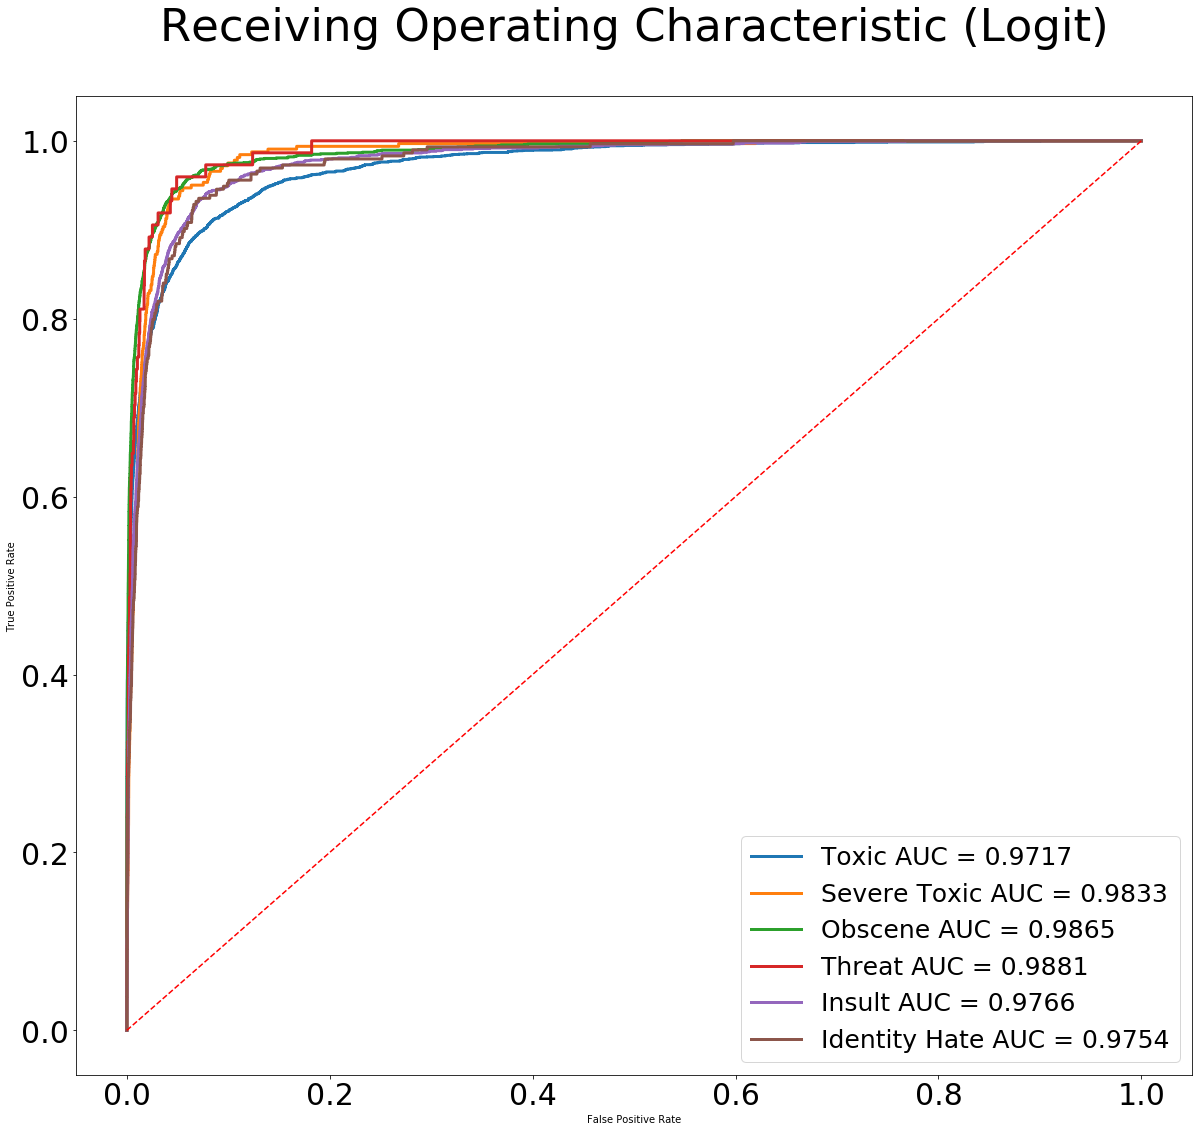

In [18]:
# Plot ROC Curves on out of sample data
fig, ax = plt.subplots(figsize=(20,18))
fig.patch.set_facecolor('white')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.rcParams.update({'font.size': 30})

y_pred_toxic = list(logistic_grid_toxic.predict_proba(X_test_toxic)[:,1])
label_toxic = y_test_toxic
fpr, tpr, thresh = metrics.roc_curve(label_toxic, y_pred_toxic)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label=("Toxic AUC = %0.4f" %roc_auc),linewidth=3.0)

y_pred_severe_toxic = list(logistic_grid_severe_toxic.predict_proba(X_test_severe_toxic)[:,1])
label_severe_toxic = y_test_severe_toxic
fpr, tpr, thresh = metrics.roc_curve(label_severe_toxic, y_pred_severe_toxic)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label=("Severe Toxic AUC = %0.4f" %roc_auc),linewidth=3.0)

y_pred_obscene = list(logistic_grid_obscene.predict_proba(X_test_obscene)[:,1])
label_obscene = y_test_obscene
fpr, tpr, thresh = metrics.roc_curve(label_obscene, y_pred_obscene)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label=("Obscene AUC = %0.4f" %roc_auc),linewidth=3.0)

y_pred_threat = list(logistic_grid_threat.predict_proba(X_test_threat)[:,1])
label_threat = y_test_threat
fpr, tpr, thresh = metrics.roc_curve(label_threat, y_pred_threat)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label=("Threat AUC = %0.4f" %roc_auc),linewidth=3.0)

y_pred_insult = list(logistic_grid_insult.predict_proba(X_test_insult)[:,1])
label_insult = y_test_insult
fpr, tpr, thresh = metrics.roc_curve(label_insult, y_pred_insult)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label=("Insult AUC = %0.4f" %roc_auc),linewidth=3.0)

y_pred_identity_hate = list(logistic_grid_identity_hate.predict_proba(X_test_identity_hate)[:,1])
label_identity_hate = y_test_identity_hate
fpr, tpr, thresh = metrics.roc_curve(label_identity_hate, y_pred_identity_hate)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label=("Identity Hate AUC = %0.4f" %roc_auc),linewidth=3.0)

plt.title('Receiving Operating Characteristic (Logit)\n',fontsize=45);
plt.plot([0, 1], [0, 1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=0,prop={'size': 25});

## Pickle Models
This way you don't have to re-run the models

# Applying ExtraTreeClassifier (ETC)

In [18]:
from sklearn.ensemble import ExtraTreesClassifier

losses = []
etc_predictions = {'id': test['id']}
etc_models = {}
for class_name in class_names:
    train_target = train[class_name]
    etc_classifier = ExtraTreesClassifier(n_estimators=30)
    
    cv_loss = np.mean(cross_val_score(etc_classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    losses.append(cv_loss)
    print('CV score for class {} is {}'.format(class_name, cv_loss))
    
    etc_classifier.fit(train_features, train_target)
    etc_models[class_name] = etc_classifier
    etc_predictions[class_name] = etc_classifier.predict_proba(test_features)[:, 1]

CV score for class toxic is 0.9561633352021502
CV score for class severe_toxic is 0.9375435079541407
CV score for class obscene is 0.9788115847044438
CV score for class threat is 0.8710639089080328
CV score for class insult is 0.9618367539347289
CV score for class identity_hate is 0.8979140190345815


In [ ]:
#pickle the models
# Save Model as a pickle Using joblib
# Save the model as a pickle in a file 
joblib.dump(etc_models, 'etc_models.p') 
  
# Load the model from the file 
pickled_models = joblib.load('etc_models.p')

In [ ]:
#pickled_models['toxic'].fit(train_features, train_target)
predictions['toxic'] = pickled_models['toxic'].predict_proba(test_features)[:, 1]